In [28]:
import tensorflow.keras as keras

## Using a simple logistic regression model to predict 3 classes

Logistic regression is generally used for binary classification, but it can be extended to handle multiple classes through "one-vs-all" strategy:
- One-Hot Encoding (each class should have a binary column, indicating its presence or absence)
- Training three separate logistic regression models (for each model, the target variable to the one-hot encoded vector for the corresponding class : Class 1 vs. Not Class 1, Class 2 vs. Not Class 2, Class 3 vs. Not Class 3)
- For obtain a prediction from a given input, we get predictions from all three models. The class with the highest predicted probability is the final prediction for that input.

In [29]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [30]:
df = pd.read_csv("data_pred_ci3.csv")

In [31]:
df["CI3"] = df["CI3"].apply(lambda x: 0 if x <= 0 else 1 if x < 2 else 2)

In [32]:
df["CI3"].value_counts()

0    46
1    33
2    11
Name: CI3, dtype: int64

In [33]:
y = df["CI3"].values
X = df.drop(columns=["CI3", "Unnamed: 0"]).values

print(X.shape, y.shape)

(90, 275) (90,)


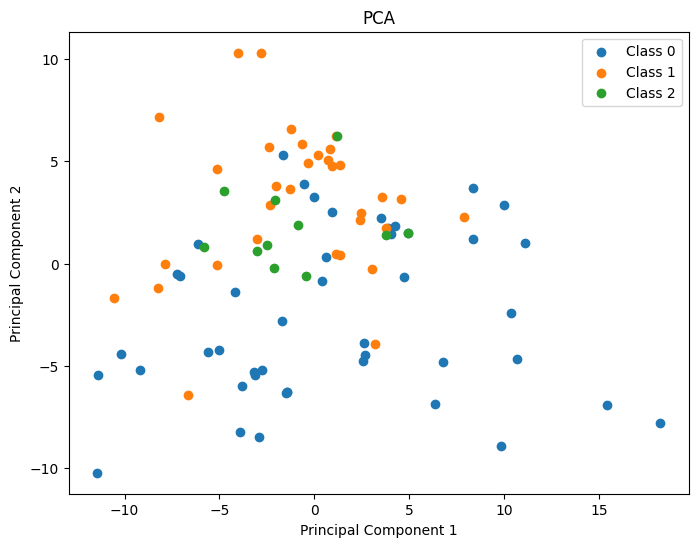

In [34]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))

for i in range(3):
    indices = (y == i)
    plt.scatter(X_pca[indices, 0], X_pca[indices, 1], label=f"Class {i}")

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA")
plt.legend()
plt.show()

In [35]:
# One-Hot Encoding
encoder = OneHotEncoder()
y_encoded = encoder.fit_transform(y.reshape(-1, 1)).toarray()

# Model Training with k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

models = []
for i in range(3):
    model = LogisticRegression(max_iter=1000)
    # Use cross_val_predict to get predictions for each fold
    predictions = cross_val_predict(model, X, y_encoded[:, i], cv=kf, method='predict_proba')[:, 1]
    models.append(predictions)

# Combine predictions and choose the class with the highest probability
final_predictions = np.argmax(models, axis=0)

# Evaluate the accuracy
accuracy = accuracy_score(y, final_predictions)
print("Accuracy:", accuracy)


Accuracy: 0.6111111111111112


In [36]:
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    rf_classifier.fit(X_train, y_train)
    y_pred = rf_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)


average_accuracy = np.mean(accuracies)
print("Average Accuracy:", round(average_accuracy, 2))


print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Average Accuracy: 0.69

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.88      0.78         8
           1       0.71      0.83      0.77         6
           2       0.00      0.00      0.00         4

    accuracy                           0.67        18
   macro avg       0.47      0.57      0.52        18
weighted avg       0.55      0.67      0.60        18


Confusion Matrix:
[[7 0 1]
 [1 5 0]
 [2 2 0]]


## Using a simple NN

In [10]:
import tensorflow as tf
from tensorflow import keras

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Un réseau possible

Réseau le plus simple, sans rien en plus, avec peu de neurones. Trois couches chacune avec 3 neurones.

Epoch 1/20
2/2 [==============================] - 3s 567ms/step - loss: 1.3471 - accuracy: 0.2361 - val_loss: 1.2636 - val_accuracy: 0.2222
Epoch 2/20
2/2 [==============================] - 0s 134ms/step - loss: 1.3120 - accuracy: 0.2222 - val_loss: 1.2493 - val_accuracy: 0.2222
Epoch 3/20
2/2 [==============================] - 0s 122ms/step - loss: 1.2842 - accuracy: 0.2361 - val_loss: 1.2349 - val_accuracy: 0.2778
Epoch 4/20
2/2 [==============================] - 0s 111ms/step - loss: 1.2591 - accuracy: 0.2639 - val_loss: 1.2194 - val_accuracy: 0.2778
Epoch 5/20
2/2 [==============================] - 0s 147ms/step - loss: 1.2367 - accuracy: 0.2639 - val_loss: 1.2058 - val_accuracy: 0.2778
Epoch 6/20
2/2 [==============================] - 0s 151ms/step - loss: 1.2162 - accuracy: 0.2917 - val_loss: 1.1934 - val_accuracy: 0.3333
Epoch 7/20
2/2 [==============================] - 0s 109ms/step - loss: 1.1982 - accuracy: 0.2917 - val_loss: 1.1818 - val_accuracy: 0.3333
Epoch 8/20
2/2 [====

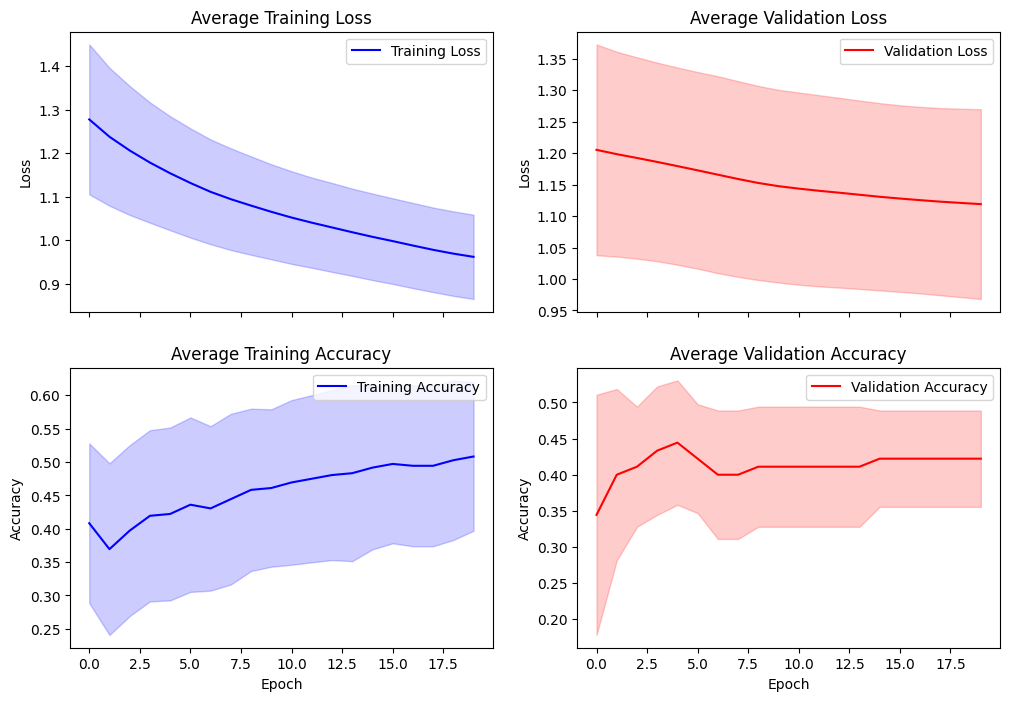

In [55]:
def create_model():
    model = keras.Sequential([
        keras.layers.Dense(3, activation='relu', input_shape=(X.shape[1],)),
        keras.layers.Dense(3, activation='relu'),
        keras.layers.Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

kf = KFold(n_splits=5, shuffle=True, random_state=42)

all_train_losses = []
all_train_accuracies = []
all_val_losses = []
all_val_accuracies = []

for train_index, test_index in kf.split(X_scaled):
    X_train, X_val = X_scaled[train_index], X_scaled[test_index]
    y_train, y_val = y[train_index], y[test_index]

    model = create_model()
    history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val))

    all_train_losses.append(history.history['loss'])
    all_val_losses.append(history.history['val_loss'])
    all_train_accuracies.append(history.history['accuracy'])
    all_val_accuracies.append(history.history['val_accuracy'])

mean_train_loss = np.mean(all_train_losses, axis=0)
mean_train_accuracy = np.mean(all_train_accuracies, axis=0)
mean_val_loss = np.mean(all_val_losses, axis=0)
mean_val_accuracy = np.mean(all_val_accuracies, axis=0)

std_train_loss = np.std(all_train_losses, axis=0)
std_train_accuracy = np.std(all_train_accuracies, axis=0)
std_val_loss = np.std(all_val_losses, axis=0)
std_val_accuracy = np.std(all_val_accuracies, axis=0)

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(mean_train_loss, 'b-', label='Training Loss')
plt.fill_between(range(len(mean_train_loss)),
                 mean_train_loss - std_train_loss,
                 mean_train_loss + std_train_loss,
                 color='blue', alpha=0.2)
plt.title('Average Training Loss')
plt.ylabel('Loss')
plt.legend()
plt.xticks(color='w')

plt.subplot(2, 2, 2)
plt.plot(mean_val_loss, 'r-', label='Validation Loss')
plt.fill_between(range(len(mean_val_loss)),
                 mean_val_loss - std_val_loss,
                 mean_val_loss + std_val_loss,
                 color='red', alpha=0.2)
plt.title('Average Validation Loss')
plt.ylabel('Loss')
plt.legend()
plt.xticks(color='w')

plt.subplot(2, 2, 3)
plt.plot(mean_train_accuracy, 'b-', label='Training Accuracy')
plt.fill_between(range(len(mean_val_accuracy)),
                 mean_train_accuracy - std_train_accuracy,
                 mean_train_accuracy + std_train_accuracy,
                 color='blue', alpha=0.2)
plt.title('Average Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(mean_val_accuracy, 'r-', label='Validation Accuracy')
plt.fill_between(range(len(mean_val_accuracy)),
                 mean_val_accuracy - std_val_accuracy,
                 mean_val_accuracy + std_val_accuracy,
                 color='red', alpha=0.2)
plt.title('Average Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Changement des paramètres pour améliorer les résultats

#### Changement du nombre de couches cachées

Deux couches cachées au lieu de une

Epoch 1/20
2/2 [==============================] - 3s 586ms/step - loss: 1.1186 - accuracy: 0.5000 - val_loss: 1.2594 - val_accuracy: 0.4444
Epoch 2/20
2/2 [==============================] - 0s 74ms/step - loss: 1.1068 - accuracy: 0.5000 - val_loss: 1.2647 - val_accuracy: 0.4444
Epoch 3/20
2/2 [==============================] - 0s 69ms/step - loss: 1.1028 - accuracy: 0.5000 - val_loss: 1.2654 - val_accuracy: 0.4444
Epoch 4/20
2/2 [==============================] - 0s 70ms/step - loss: 1.0980 - accuracy: 0.4861 - val_loss: 1.2628 - val_accuracy: 0.4444
Epoch 5/20
2/2 [==============================] - 0s 66ms/step - loss: 1.0935 - accuracy: 0.4861 - val_loss: 1.2591 - val_accuracy: 0.4444
Epoch 6/20
2/2 [==============================] - 0s 67ms/step - loss: 1.0881 - accuracy: 0.4861 - val_loss: 1.2535 - val_accuracy: 0.4444
Epoch 7/20
2/2 [==============================] - 0s 64ms/step - loss: 1.0837 - accuracy: 0.5139 - val_loss: 1.2482 - val_accuracy: 0.4444
Epoch 8/20
2/2 [==========

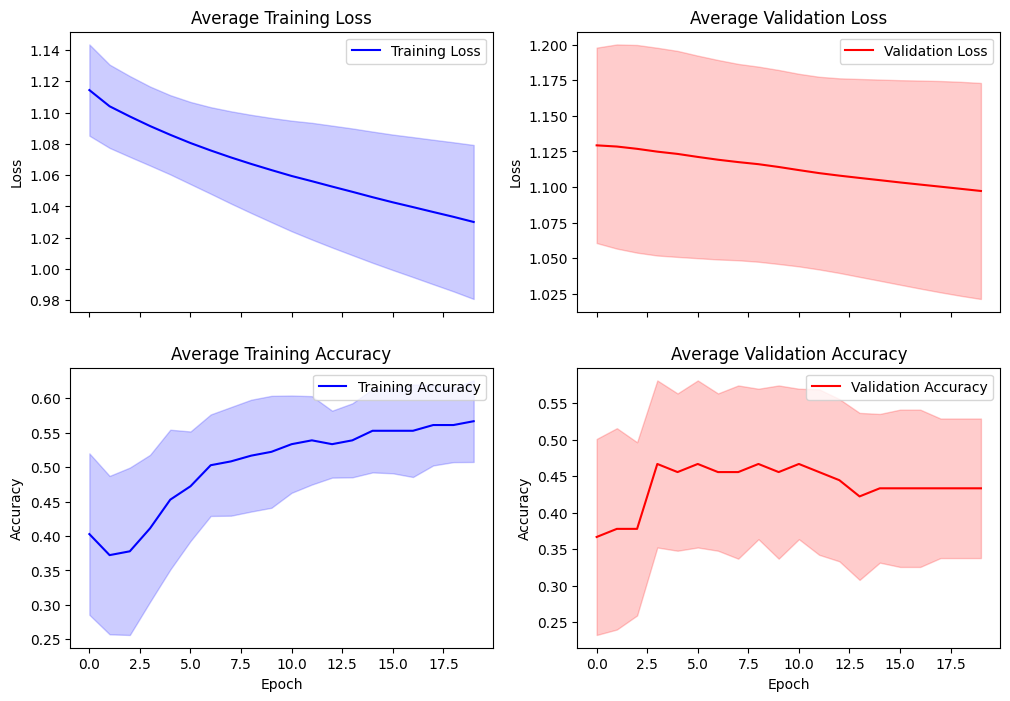

In [51]:
def create_model():
    model = keras.Sequential([
        keras.layers.Dense(3, activation='relu', input_shape=(X.shape[1],)),
        keras.layers.Dense(3, activation='relu'),
        keras.layers.Dense(3, activation='relu'),
        keras.layers.Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

kf = KFold(n_splits=5, shuffle=True, random_state=42)

all_train_losses = []
all_train_accuracies = []
all_val_losses = []
all_val_accuracies = []

for train_index, test_index in kf.split(X_scaled):
    X_train, X_val = X_scaled[train_index], X_scaled[test_index]
    y_train, y_val = y[train_index], y[test_index]

    model = create_model()
    history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val))

    all_train_losses.append(history.history['loss'])
    all_val_losses.append(history.history['val_loss'])
    all_train_accuracies.append(history.history['accuracy'])
    all_val_accuracies.append(history.history['val_accuracy'])

mean_train_loss = np.mean(all_train_losses, axis=0)
mean_train_accuracy = np.mean(all_train_accuracies, axis=0)
mean_val_loss = np.mean(all_val_losses, axis=0)
mean_val_accuracy = np.mean(all_val_accuracies, axis=0)

std_train_loss = np.std(all_train_losses, axis=0)
std_train_accuracy = np.std(all_train_accuracies, axis=0)
std_val_loss = np.std(all_val_losses, axis=0)
std_val_accuracy = np.std(all_val_accuracies, axis=0)

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(mean_train_loss, 'b-', label='Training Loss')
plt.fill_between(range(len(mean_train_loss)),
                 mean_train_loss - std_train_loss,
                 mean_train_loss + std_train_loss,
                 color='blue', alpha=0.2)
plt.title('Average Training Loss')
plt.ylabel('Loss')
plt.legend()
plt.xticks(color='w')

plt.subplot(2, 2, 2)
plt.plot(mean_val_loss, 'r-', label='Validation Loss')
plt.fill_between(range(len(mean_val_loss)),
                 mean_val_loss - std_val_loss,
                 mean_val_loss + std_val_loss,
                 color='red', alpha=0.2)
plt.title('Average Validation Loss')
plt.ylabel('Loss')
plt.legend()
plt.xticks(color='w')

plt.subplot(2, 2, 3)
plt.plot(mean_train_accuracy, 'b-', label='Training Accuracy')
plt.fill_between(range(len(mean_val_accuracy)),
                 mean_train_accuracy - std_train_accuracy,
                 mean_train_accuracy + std_train_accuracy,
                 color='blue', alpha=0.2)
plt.title('Average Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(mean_val_accuracy, 'r-', label='Validation Accuracy')
plt.fill_between(range(len(mean_val_accuracy)),
                 mean_val_accuracy - std_val_accuracy,
                 mean_val_accuracy + std_val_accuracy,
                 color='red', alpha=0.2)
plt.title('Average Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

3 couches cachées au lieu de deux

Epoch 1/20
2/2 [==============================] - 2s 520ms/step - loss: 1.1231 - accuracy: 0.1528 - val_loss: 1.1059 - val_accuracy: 0.2222
Epoch 2/20
2/2 [==============================] - 0s 102ms/step - loss: 1.1112 - accuracy: 0.2361 - val_loss: 1.1023 - val_accuracy: 0.3333
Epoch 3/20
2/2 [==============================] - 0s 107ms/step - loss: 1.1034 - accuracy: 0.3333 - val_loss: 1.1001 - val_accuracy: 0.3333
Epoch 4/20
2/2 [==============================] - 0s 110ms/step - loss: 1.0960 - accuracy: 0.3333 - val_loss: 1.0978 - val_accuracy: 0.3333
Epoch 5/20
2/2 [==============================] - 0s 111ms/step - loss: 1.0903 - accuracy: 0.3611 - val_loss: 1.0959 - val_accuracy: 0.5000
Epoch 6/20
2/2 [==============================] - 0s 114ms/step - loss: 1.0855 - accuracy: 0.3889 - val_loss: 1.0938 - val_accuracy: 0.3333
Epoch 7/20
2/2 [==============================] - 0s 105ms/step - loss: 1.0808 - accuracy: 0.4583 - val_loss: 1.0917 - val_accuracy: 0.3333
Epoch 8/20
2/2 [====

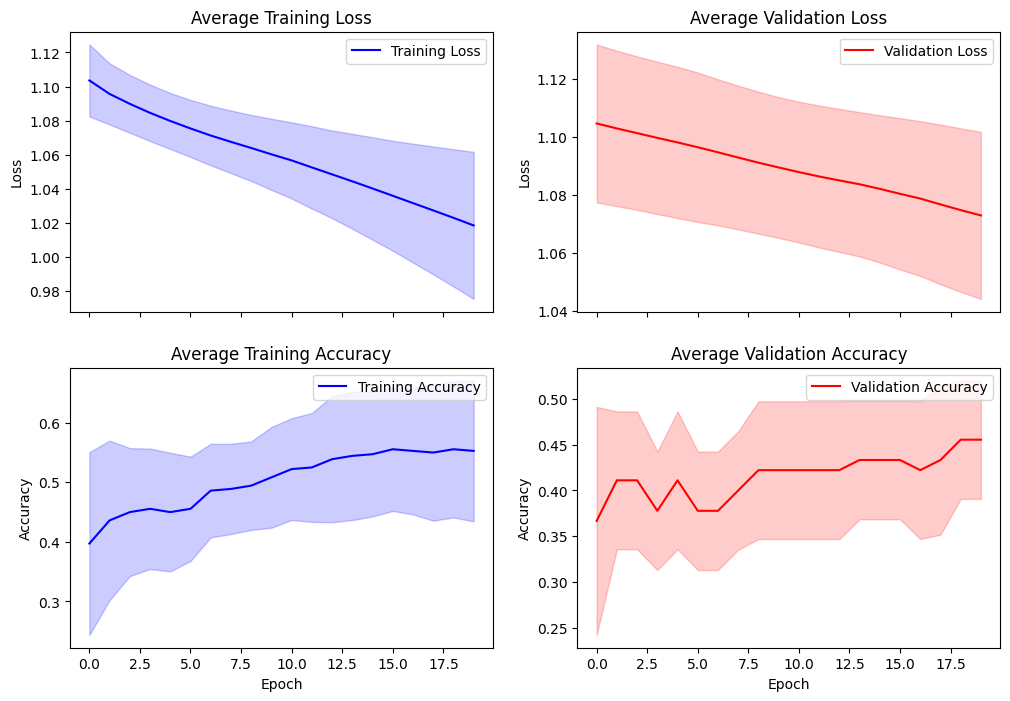

In [52]:
def create_model():
    model = keras.Sequential([
        keras.layers.Dense(3, activation='relu', input_shape=(X.shape[1],)),
        keras.layers.Dense(3, activation='relu'),
        keras.layers.Dense(3, activation='relu'),
        keras.layers.Dense(3, activation='relu'),
        keras.layers.Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

kf = KFold(n_splits=5, shuffle=True, random_state=42)

all_train_losses = []
all_train_accuracies = []
all_val_losses = []
all_val_accuracies = []

for train_index, test_index in kf.split(X_scaled):
    X_train, X_val = X_scaled[train_index], X_scaled[test_index]
    y_train, y_val = y[train_index], y[test_index]

    model = create_model()
    history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val))

    all_train_losses.append(history.history['loss'])
    all_val_losses.append(history.history['val_loss'])
    all_train_accuracies.append(history.history['accuracy'])
    all_val_accuracies.append(history.history['val_accuracy'])

mean_train_loss = np.mean(all_train_losses, axis=0)
mean_train_accuracy = np.mean(all_train_accuracies, axis=0)
mean_val_loss = np.mean(all_val_losses, axis=0)
mean_val_accuracy = np.mean(all_val_accuracies, axis=0)

std_train_loss = np.std(all_train_losses, axis=0)
std_train_accuracy = np.std(all_train_accuracies, axis=0)
std_val_loss = np.std(all_val_losses, axis=0)
std_val_accuracy = np.std(all_val_accuracies, axis=0)

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(mean_train_loss, 'b-', label='Training Loss')
plt.fill_between(range(len(mean_train_loss)),
                 mean_train_loss - std_train_loss,
                 mean_train_loss + std_train_loss,
                 color='blue', alpha=0.2)
plt.title('Average Training Loss')
plt.ylabel('Loss')
plt.legend()
plt.xticks(color='w')

plt.subplot(2, 2, 2)
plt.plot(mean_val_loss, 'r-', label='Validation Loss')
plt.fill_between(range(len(mean_val_loss)),
                 mean_val_loss - std_val_loss,
                 mean_val_loss + std_val_loss,
                 color='red', alpha=0.2)
plt.title('Average Validation Loss')
plt.ylabel('Loss')
plt.legend()
plt.xticks(color='w')

plt.subplot(2, 2, 3)
plt.plot(mean_train_accuracy, 'b-', label='Training Accuracy')
plt.fill_between(range(len(mean_val_accuracy)),
                 mean_train_accuracy - std_train_accuracy,
                 mean_train_accuracy + std_train_accuracy,
                 color='blue', alpha=0.2)
plt.title('Average Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(mean_val_accuracy, 'r-', label='Validation Accuracy')
plt.fill_between(range(len(mean_val_accuracy)),
                 mean_val_accuracy - std_val_accuracy,
                 mean_val_accuracy + std_val_accuracy,
                 color='red', alpha=0.2)
plt.title('Average Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Le mieux ici c'est une seule couche cachée.

#### Changement du nombre de neurones dans les couches

Deux fois plus en entrée qu'en cachées

Epoch 1/20
2/2 [==============================] - 2s 347ms/step - loss: 1.4096 - accuracy: 0.2917 - val_loss: 1.5427 - val_accuracy: 0.2778
Epoch 2/20
2/2 [==============================] - 0s 70ms/step - loss: 1.2319 - accuracy: 0.3750 - val_loss: 1.4923 - val_accuracy: 0.2778
Epoch 3/20
2/2 [==============================] - 0s 92ms/step - loss: 1.1115 - accuracy: 0.4167 - val_loss: 1.4560 - val_accuracy: 0.3889
Epoch 4/20
2/2 [==============================] - 0s 69ms/step - loss: 1.0166 - accuracy: 0.4583 - val_loss: 1.4260 - val_accuracy: 0.3889
Epoch 5/20
2/2 [==============================] - 0s 110ms/step - loss: 0.9406 - accuracy: 0.5000 - val_loss: 1.3936 - val_accuracy: 0.4444
Epoch 6/20
2/2 [==============================] - 0s 114ms/step - loss: 0.8789 - accuracy: 0.5417 - val_loss: 1.3677 - val_accuracy: 0.4444
Epoch 7/20
2/2 [==============================] - 0s 99ms/step - loss: 0.8248 - accuracy: 0.5833 - val_loss: 1.3431 - val_accuracy: 0.4444
Epoch 8/20
2/2 [========

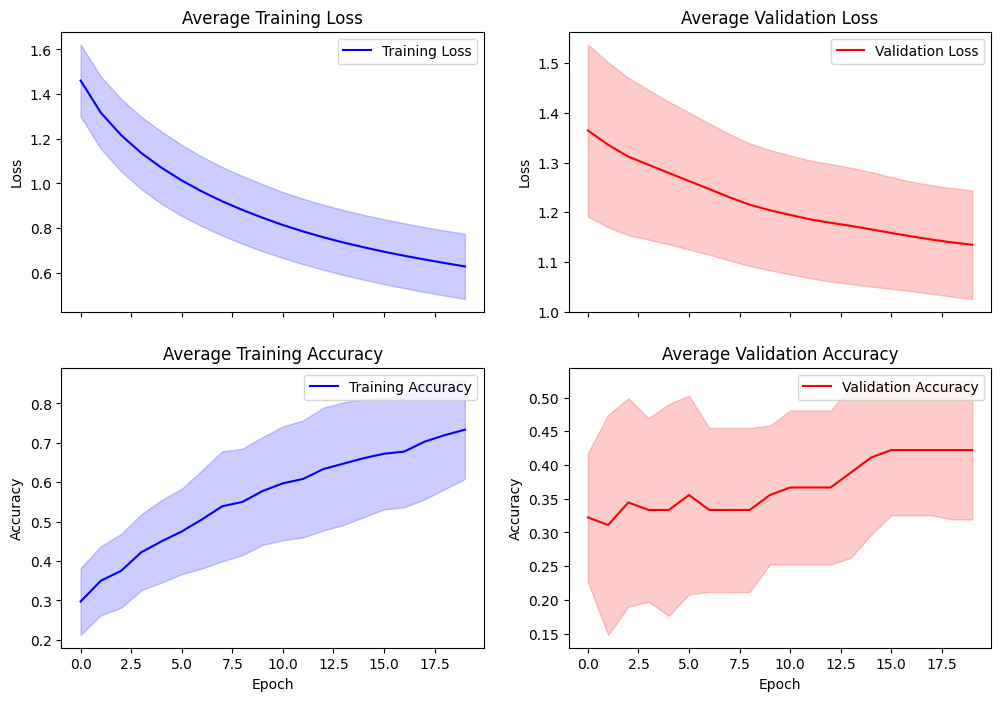

In [53]:
def create_model():
    model = keras.Sequential([
        keras.layers.Dense(16, activation='relu', input_shape=(X.shape[1],)),
        keras.layers.Dense(8, activation='relu'),
        keras.layers.Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

kf = KFold(n_splits=5, shuffle=True, random_state=42)

all_train_losses = []
all_train_accuracies = []
all_val_losses = []
all_val_accuracies = []

for train_index, test_index in kf.split(X_scaled):
    X_train, X_val = X_scaled[train_index], X_scaled[test_index]
    y_train, y_val = y[train_index], y[test_index]

    model = create_model()
    history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val))

    all_train_losses.append(history.history['loss'])
    all_val_losses.append(history.history['val_loss'])
    all_train_accuracies.append(history.history['accuracy'])
    all_val_accuracies.append(history.history['val_accuracy'])

mean_train_loss = np.mean(all_train_losses, axis=0)
mean_train_accuracy = np.mean(all_train_accuracies, axis=0)
mean_val_loss = np.mean(all_val_losses, axis=0)
mean_val_accuracy = np.mean(all_val_accuracies, axis=0)

std_train_loss = np.std(all_train_losses, axis=0)
std_train_accuracy = np.std(all_train_accuracies, axis=0)
std_val_loss = np.std(all_val_losses, axis=0)
std_val_accuracy = np.std(all_val_accuracies, axis=0)

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(mean_train_loss, 'b-', label='Training Loss')
plt.fill_between(range(len(mean_train_loss)),
                 mean_train_loss - std_train_loss,
                 mean_train_loss + std_train_loss,
                 color='blue', alpha=0.2)
plt.title('Average Training Loss')
plt.ylabel('Loss')
plt.legend()
plt.xticks(color='w')

plt.subplot(2, 2, 2)
plt.plot(mean_val_loss, 'r-', label='Validation Loss')
plt.fill_between(range(len(mean_val_loss)),
                 mean_val_loss - std_val_loss,
                 mean_val_loss + std_val_loss,
                 color='red', alpha=0.2)
plt.title('Average Validation Loss')
plt.ylabel('Loss')
plt.legend()
plt.xticks(color='w')

plt.subplot(2, 2, 3)
plt.plot(mean_train_accuracy, 'b-', label='Training Accuracy')
plt.fill_between(range(len(mean_val_accuracy)),
                 mean_train_accuracy - std_train_accuracy,
                 mean_train_accuracy + std_train_accuracy,
                 color='blue', alpha=0.2)
plt.title('Average Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(mean_val_accuracy, 'r-', label='Validation Accuracy')
plt.fill_between(range(len(mean_val_accuracy)),
                 mean_val_accuracy - std_val_accuracy,
                 mean_val_accuracy + std_val_accuracy,
                 color='red', alpha=0.2)
plt.title('Average Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Deux fois plus en cachée qu'en entrée

Epoch 1/20
2/2 [==============================] - 2s 331ms/step - loss: 1.3955 - accuracy: 0.3333 - val_loss: 1.3122 - val_accuracy: 0.3889
Epoch 2/20
2/2 [==============================] - 0s 64ms/step - loss: 1.3021 - accuracy: 0.3472 - val_loss: 1.2726 - val_accuracy: 0.3889
Epoch 3/20
2/2 [==============================] - 0s 78ms/step - loss: 1.2359 - accuracy: 0.4028 - val_loss: 1.2385 - val_accuracy: 0.4444
Epoch 4/20
2/2 [==============================] - 0s 77ms/step - loss: 1.1799 - accuracy: 0.4444 - val_loss: 1.2092 - val_accuracy: 0.4444
Epoch 5/20
2/2 [==============================] - 0s 71ms/step - loss: 1.1283 - accuracy: 0.4583 - val_loss: 1.1841 - val_accuracy: 0.4444
Epoch 6/20
2/2 [==============================] - 0s 66ms/step - loss: 1.0863 - accuracy: 0.4722 - val_loss: 1.1624 - val_accuracy: 0.4444
Epoch 7/20
2/2 [==============================] - 0s 62ms/step - loss: 1.0493 - accuracy: 0.4861 - val_loss: 1.1447 - val_accuracy: 0.4444
Epoch 8/20
2/2 [==========

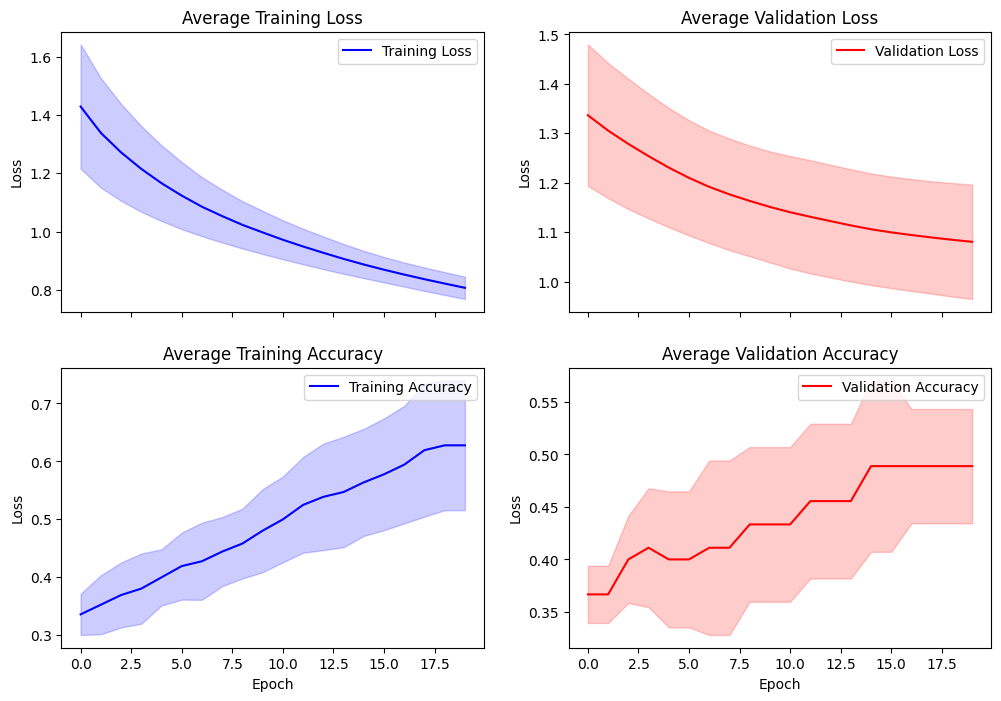

In [49]:
def create_model():
    model = keras.Sequential([
        keras.layers.Dense(8, activation='relu', input_shape=(X.shape[1],)),
        keras.layers.Dense(16, activation='relu'),
        keras.layers.Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

kf = KFold(n_splits=5, shuffle=True, random_state=42)

all_train_losses = []
all_train_accuracies = []
all_val_losses = []
all_val_accuracies = []

for train_index, test_index in kf.split(X_scaled):
    X_train, X_val = X_scaled[train_index], X_scaled[test_index]
    y_train, y_val = y[train_index], y[test_index]

    model = create_model()
    history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val))

    all_train_losses.append(history.history['loss'])
    all_val_losses.append(history.history['val_loss'])
    all_train_accuracies.append(history.history['accuracy'])
    all_val_accuracies.append(history.history['val_accuracy'])

mean_train_loss = np.mean(all_train_losses, axis=0)
mean_train_accuracy = np.mean(all_train_accuracies, axis=0)
mean_val_loss = np.mean(all_val_losses, axis=0)
mean_val_accuracy = np.mean(all_val_accuracies, axis=0)

std_train_loss = np.std(all_train_losses, axis=0)
std_train_accuracy = np.std(all_train_accuracies, axis=0)
std_val_loss = np.std(all_val_losses, axis=0)
std_val_accuracy = np.std(all_val_accuracies, axis=0)

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(mean_train_loss, 'b-', label='Training Loss')
plt.fill_between(range(len(mean_train_loss)),
                 mean_train_loss - std_train_loss,
                 mean_train_loss + std_train_loss,
                 color='blue', alpha=0.2)
plt.title('Average Training Loss')
plt.ylabel('Loss')
plt.legend()
plt.xticks(color='w')

plt.subplot(2, 2, 2)
plt.plot(mean_val_loss, 'r-', label='Validation Loss')
plt.fill_between(range(len(mean_val_loss)),
                 mean_val_loss - std_val_loss,
                 mean_val_loss + std_val_loss,
                 color='red', alpha=0.2)
plt.title('Average Validation Loss')
plt.ylabel('Loss')
plt.legend()
plt.xticks(color='w')

plt.subplot(2, 2, 3)
plt.plot(mean_train_accuracy, 'b-', label='Training Accuracy')
plt.fill_between(range(len(mean_val_accuracy)),
                 mean_train_accuracy - std_train_accuracy,
                 mean_train_accuracy + std_train_accuracy,
                 color='blue', alpha=0.2)
plt.title('Average Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(mean_val_accuracy, 'r-', label='Validation Accuracy')
plt.fill_between(range(len(mean_val_accuracy)),
                 mean_val_accuracy - std_val_accuracy,
                 mean_val_accuracy + std_val_accuracy,
                 color='red', alpha=0.2)
plt.title('Average Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

On a les meilleurs résultats avec deux fois plus de neurones en couches cachées qu'en couche d'entrée

#### Changement du nombre d'epoch

50 epoch

Epoch 1/50
2/2 [==============================] - 2s 691ms/step - loss: 1.4321 - accuracy: 0.2778 - val_loss: 1.3351 - val_accuracy: 0.2778
Epoch 2/50
2/2 [==============================] - 0s 135ms/step - loss: 1.3341 - accuracy: 0.2917 - val_loss: 1.3033 - val_accuracy: 0.2222
Epoch 3/50
2/2 [==============================] - 0s 73ms/step - loss: 1.2522 - accuracy: 0.3194 - val_loss: 1.2726 - val_accuracy: 0.2778
Epoch 4/50
2/2 [==============================] - 0s 121ms/step - loss: 1.1864 - accuracy: 0.3611 - val_loss: 1.2364 - val_accuracy: 0.3333
Epoch 5/50
2/2 [==============================] - 0s 118ms/step - loss: 1.1271 - accuracy: 0.4306 - val_loss: 1.2042 - val_accuracy: 0.3333
Epoch 6/50
2/2 [==============================] - 0s 93ms/step - loss: 1.0733 - accuracy: 0.4583 - val_loss: 1.1775 - val_accuracy: 0.3889
Epoch 7/50
2/2 [==============================] - 0s 126ms/step - loss: 1.0286 - accuracy: 0.5139 - val_loss: 1.1557 - val_accuracy: 0.3889
Epoch 8/50
2/2 [======

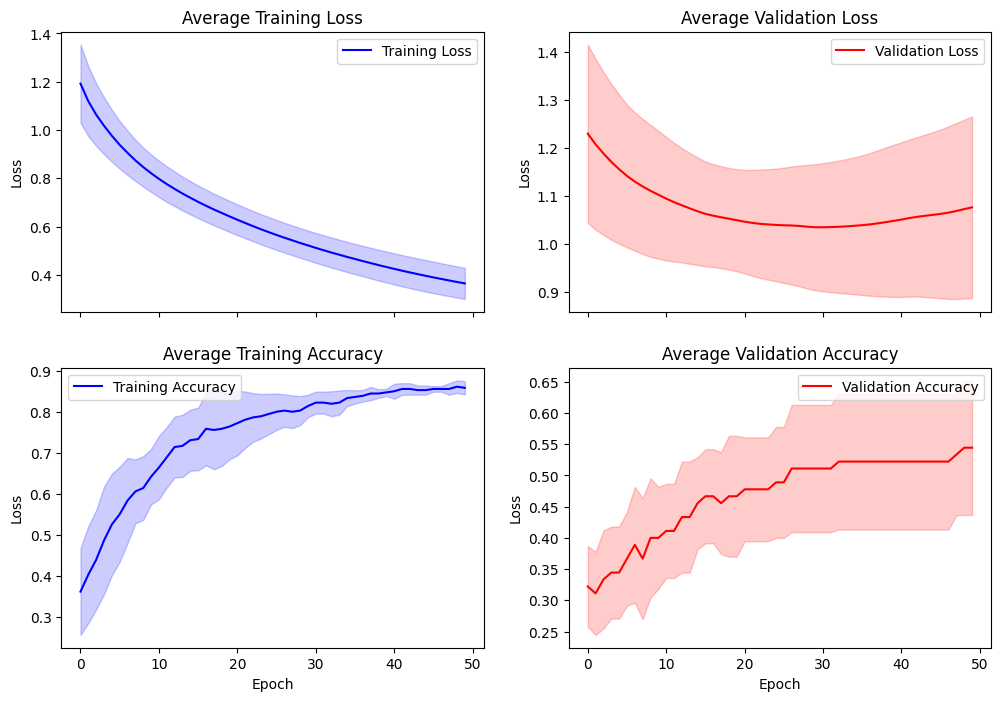

In [56]:
def create_model():
    model = keras.Sequential([
        keras.layers.Dense(8, activation='relu', input_shape=(X.shape[1],)),
        keras.layers.Dense(16, activation='relu'),
        keras.layers.Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

kf = KFold(n_splits=5, shuffle=True, random_state=42)

all_train_losses = []
all_train_accuracies = []
all_val_losses = []
all_val_accuracies = []

for train_index, test_index in kf.split(X_scaled):
    X_train, X_val = X_scaled[train_index], X_scaled[test_index]
    y_train, y_val = y[train_index], y[test_index]

    model = create_model()
    history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

    all_train_losses.append(history.history['loss'])
    all_val_losses.append(history.history['val_loss'])
    all_train_accuracies.append(history.history['accuracy'])
    all_val_accuracies.append(history.history['val_accuracy'])

mean_train_loss = np.mean(all_train_losses, axis=0)
mean_train_accuracy = np.mean(all_train_accuracies, axis=0)
mean_val_loss = np.mean(all_val_losses, axis=0)
mean_val_accuracy = np.mean(all_val_accuracies, axis=0)

std_train_loss = np.std(all_train_losses, axis=0)
std_train_accuracy = np.std(all_train_accuracies, axis=0)
std_val_loss = np.std(all_val_losses, axis=0)
std_val_accuracy = np.std(all_val_accuracies, axis=0)

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(mean_train_loss, 'b-', label='Training Loss')
plt.fill_between(range(len(mean_train_loss)),
                 mean_train_loss - std_train_loss,
                 mean_train_loss + std_train_loss,
                 color='blue', alpha=0.2)
plt.title('Average Training Loss')
plt.ylabel('Loss')
plt.legend()
plt.xticks(color='w')

plt.subplot(2, 2, 2)
plt.plot(mean_val_loss, 'r-', label='Validation Loss')
plt.fill_between(range(len(mean_val_loss)),
                 mean_val_loss - std_val_loss,
                 mean_val_loss + std_val_loss,
                 color='red', alpha=0.2)
plt.title('Average Validation Loss')
plt.ylabel('Loss')
plt.legend()
plt.xticks(color='w')

plt.subplot(2, 2, 3)
plt.plot(mean_train_accuracy, 'b-', label='Training Accuracy')
plt.fill_between(range(len(mean_val_accuracy)),
                 mean_train_accuracy - std_train_accuracy,
                 mean_train_accuracy + std_train_accuracy,
                 color='blue', alpha=0.2)
plt.title('Average Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(mean_val_accuracy, 'r-', label='Validation Accuracy')
plt.fill_between(range(len(mean_val_accuracy)),
                 mean_val_accuracy - std_val_accuracy,
                 mean_val_accuracy + std_val_accuracy,
                 color='red', alpha=0.2)
plt.title('Average Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

100 epoch

Epoch 1/100
2/2 [==============================] - 3s 605ms/step - loss: 1.0819 - accuracy: 0.3611 - val_loss: 1.1393 - val_accuracy: 0.4444
Epoch 2/100
2/2 [==============================] - 0s 97ms/step - loss: 1.0326 - accuracy: 0.4167 - val_loss: 1.1286 - val_accuracy: 0.4444
Epoch 3/100
2/2 [==============================] - 0s 71ms/step - loss: 0.9997 - accuracy: 0.4444 - val_loss: 1.1196 - val_accuracy: 0.4444
Epoch 4/100
2/2 [==============================] - 0s 77ms/step - loss: 0.9713 - accuracy: 0.4444 - val_loss: 1.1130 - val_accuracy: 0.4444
Epoch 5/100
2/2 [==============================] - 0s 65ms/step - loss: 0.9451 - accuracy: 0.4306 - val_loss: 1.1074 - val_accuracy: 0.4444
Epoch 6/100
2/2 [==============================] - 0s 64ms/step - loss: 0.9213 - accuracy: 0.4722 - val_loss: 1.1023 - val_accuracy: 0.4444
Epoch 7/100
2/2 [==============================] - 0s 71ms/step - loss: 0.8996 - accuracy: 0.5000 - val_loss: 1.0979 - val_accuracy: 0.4444
Epoch 8/100
2/2 [==

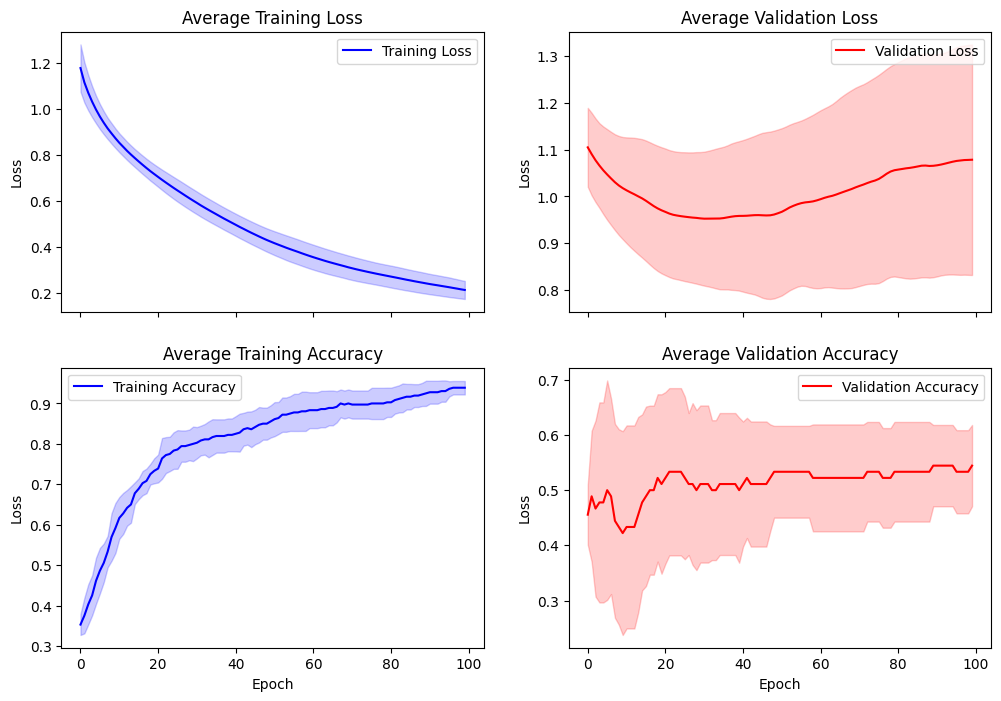

In [57]:
def create_model():
    model = keras.Sequential([
        keras.layers.Dense(8, activation='relu', input_shape=(X.shape[1],)),
        keras.layers.Dense(16, activation='relu'),
        keras.layers.Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

kf = KFold(n_splits=5, shuffle=True, random_state=42)

all_train_losses = []
all_train_accuracies = []
all_val_losses = []
all_val_accuracies = []

for train_index, test_index in kf.split(X_scaled):
    X_train, X_val = X_scaled[train_index], X_scaled[test_index]
    y_train, y_val = y[train_index], y[test_index]

    model = create_model()
    history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val))

    all_train_losses.append(history.history['loss'])
    all_val_losses.append(history.history['val_loss'])
    all_train_accuracies.append(history.history['accuracy'])
    all_val_accuracies.append(history.history['val_accuracy'])

mean_train_loss = np.mean(all_train_losses, axis=0)
mean_train_accuracy = np.mean(all_train_accuracies, axis=0)
mean_val_loss = np.mean(all_val_losses, axis=0)
mean_val_accuracy = np.mean(all_val_accuracies, axis=0)

std_train_loss = np.std(all_train_losses, axis=0)
std_train_accuracy = np.std(all_train_accuracies, axis=0)
std_val_loss = np.std(all_val_losses, axis=0)
std_val_accuracy = np.std(all_val_accuracies, axis=0)

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(mean_train_loss, 'b-', label='Training Loss')
plt.fill_between(range(len(mean_train_loss)),
                 mean_train_loss - std_train_loss,
                 mean_train_loss + std_train_loss,
                 color='blue', alpha=0.2)
plt.title('Average Training Loss')
plt.ylabel('Loss')
plt.legend()
plt.xticks(color='w')

plt.subplot(2, 2, 2)
plt.plot(mean_val_loss, 'r-', label='Validation Loss')
plt.fill_between(range(len(mean_val_loss)),
                 mean_val_loss - std_val_loss,
                 mean_val_loss + std_val_loss,
                 color='red', alpha=0.2)
plt.title('Average Validation Loss')
plt.ylabel('Loss')
plt.legend()
plt.xticks(color='w')

plt.subplot(2, 2, 3)
plt.plot(mean_train_accuracy, 'b-', label='Training Accuracy')
plt.fill_between(range(len(mean_val_accuracy)),
                 mean_train_accuracy - std_train_accuracy,
                 mean_train_accuracy + std_train_accuracy,
                 color='blue', alpha=0.2)
plt.title('Average Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(mean_val_accuracy, 'r-', label='Validation Accuracy')
plt.fill_between(range(len(mean_val_accuracy)),
                 mean_val_accuracy - std_val_accuracy,
                 mean_val_accuracy + std_val_accuracy,
                 color='red', alpha=0.2)
plt.title('Average Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

On a un cas classique d'overfitting pour 50 et 100 epoch. Il faut mettre en place de la régularisation.

# RECHERCHES
après ça c'est des trucs en vrac

Epoch 1/20
2/2 [==============================] - 3s 729ms/step - loss: 5.2732 - accuracy: 0.2083 - val_loss: 5.0928 - val_accuracy: 0.4444
Epoch 2/20
2/2 [==============================] - 0s 72ms/step - loss: 5.1177 - accuracy: 0.3333 - val_loss: 4.9977 - val_accuracy: 0.4444
Epoch 3/20
2/2 [==============================] - 0s 71ms/step - loss: 5.0182 - accuracy: 0.3194 - val_loss: 4.9080 - val_accuracy: 0.4444
Epoch 4/20
2/2 [==============================] - 0s 71ms/step - loss: 4.8774 - accuracy: 0.3750 - val_loss: 4.8223 - val_accuracy: 0.5000
Epoch 5/20
2/2 [==============================] - 0s 74ms/step - loss: 4.7552 - accuracy: 0.4167 - val_loss: 4.7404 - val_accuracy: 0.5000
Epoch 6/20
2/2 [==============================] - 0s 71ms/step - loss: 4.6588 - accuracy: 0.4722 - val_loss: 4.6606 - val_accuracy: 0.3889
Epoch 7/20
2/2 [==============================] - 0s 70ms/step - loss: 4.5280 - accuracy: 0.5556 - val_loss: 4.5836 - val_accuracy: 0.3889
Epoch 8/20
2/2 [==========

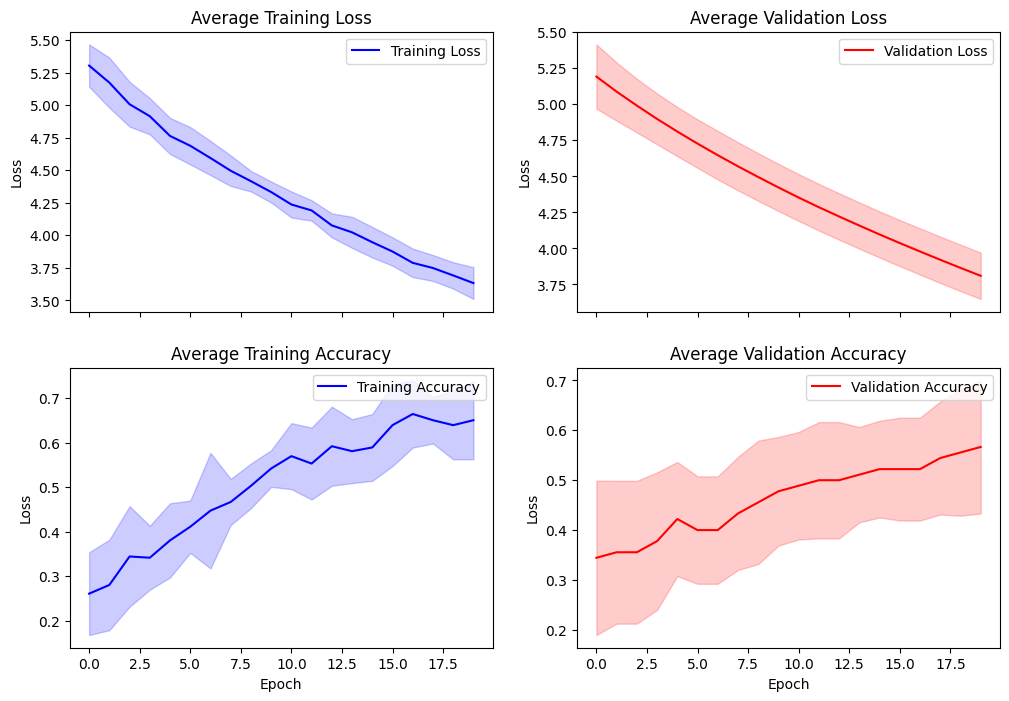

In [37]:
def create_model(l2_reg=0.05):
    model = keras.Sequential([
        keras.layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(l2_reg), input_shape=(X.shape[1],)),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l2(l2_reg)),
        keras.layers.Dense(8, activation='relu'),
        keras.layers.Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

kf = KFold(n_splits=5, shuffle=True, random_state=42)

all_train_losses = []
all_train_accuracies = []
all_val_losses = []
all_val_accuracies = []

for train_index, test_index in kf.split(X_scaled):
    X_train, X_val = X_scaled[train_index], X_scaled[test_index]
    y_train, y_val = y[train_index], y[test_index]

    model = create_model()
    history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val))

    all_train_losses.append(history.history['loss'])
    all_val_losses.append(history.history['val_loss'])
    all_train_accuracies.append(history.history['accuracy'])
    all_val_accuracies.append(history.history['val_accuracy'])

mean_train_loss = np.mean(all_train_losses, axis=0)
mean_train_accuracy = np.mean(all_train_accuracies, axis=0)
mean_val_loss = np.mean(all_val_losses, axis=0)
mean_val_accuracy = np.mean(all_val_accuracies, axis=0)

std_train_loss = np.std(all_train_losses, axis=0)
std_train_accuracy = np.std(all_train_accuracies, axis=0)
std_val_loss = np.std(all_val_losses, axis=0)
std_val_accuracy = np.std(all_val_accuracies, axis=0)

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(mean_train_loss, 'b-', label='Training Loss')
plt.fill_between(range(len(mean_train_loss)),
                 mean_train_loss - std_train_loss,
                 mean_train_loss + std_train_loss,
                 color='blue', alpha=0.2)
plt.title('Average Training Loss')
plt.ylabel('Loss')
plt.legend()
plt.xticks(color='w')

plt.subplot(2, 2, 2)
plt.plot(mean_val_loss, 'r-', label='Validation Loss')
plt.fill_between(range(len(mean_val_loss)),
                 mean_val_loss - std_val_loss,
                 mean_val_loss + std_val_loss,
                 color='red', alpha=0.2)
plt.title('Average Validation Loss')
plt.ylabel('Loss')
plt.legend()
plt.xticks(color='w')

plt.subplot(2, 2, 3)
plt.plot(mean_train_accuracy, 'b-', label='Training Accuracy')
plt.fill_between(range(len(mean_val_accuracy)),
                 mean_train_accuracy - std_train_accuracy,
                 mean_train_accuracy + std_train_accuracy,
                 color='blue', alpha=0.2)
plt.title('Average Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(mean_val_accuracy, 'r-', label='Validation Accuracy')
plt.fill_between(range(len(mean_val_accuracy)),
                 mean_val_accuracy - std_val_accuracy,
                 mean_val_accuracy + std_val_accuracy,
                 color='red', alpha=0.2)
plt.title('Average Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

#### Changement du nombre d'epoch

Epoch 1/10
2/2 [==============================] - 1s 295ms/step - loss: 5.5671 - accuracy: 0.1389 - val_loss: 5.2242 - val_accuracy: 0.1111
Epoch 2/10
2/2 [==============================] - 0s 55ms/step - loss: 5.3123 - accuracy: 0.1944 - val_loss: 5.1094 - val_accuracy: 0.1111
Epoch 3/10
2/2 [==============================] - 0s 70ms/step - loss: 5.1784 - accuracy: 0.1806 - val_loss: 5.0046 - val_accuracy: 0.1667
Epoch 4/10
2/2 [==============================] - 0s 60ms/step - loss: 5.0687 - accuracy: 0.1944 - val_loss: 4.9119 - val_accuracy: 0.2222
Epoch 5/10
2/2 [==============================] - 0s 46ms/step - loss: 4.9198 - accuracy: 0.2361 - val_loss: 4.8236 - val_accuracy: 0.2222
Epoch 6/10
2/2 [==============================] - 0s 45ms/step - loss: 4.9062 - accuracy: 0.2361 - val_loss: 4.7394 - val_accuracy: 0.2222
Epoch 7/10
2/2 [==============================] - 0s 59ms/step - loss: 4.7129 - accuracy: 0.2639 - val_loss: 4.6627 - val_accuracy: 0.2778
Epoch 8/10
2/2 [==========

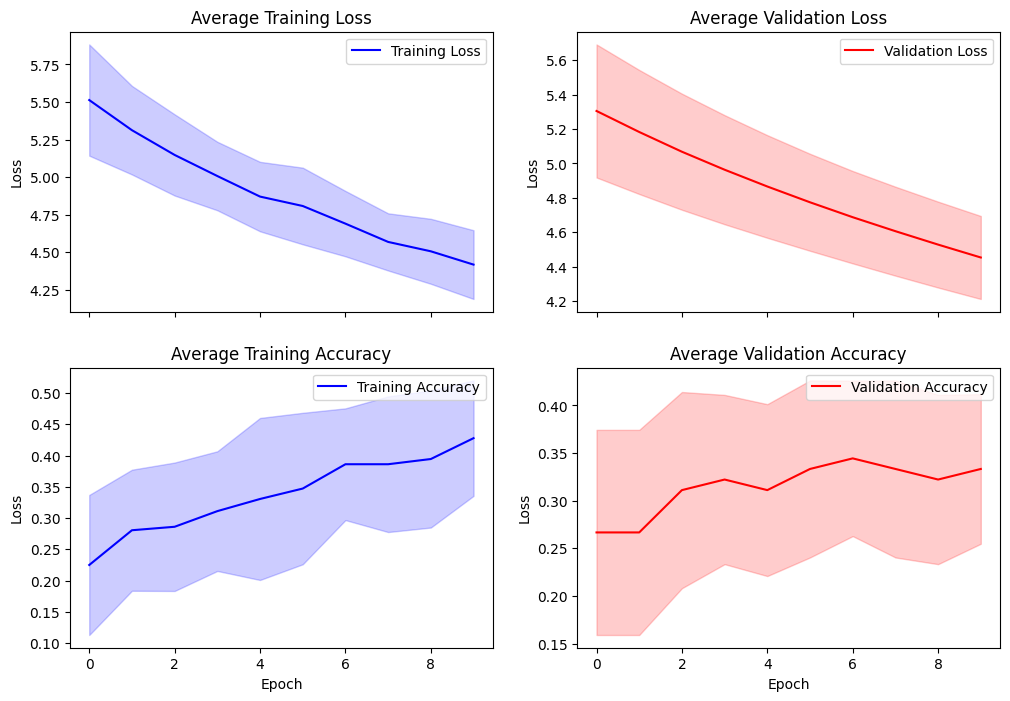

In [38]:
def create_model(l2_reg=0.05):
    model = keras.Sequential([
        keras.layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(l2_reg), input_shape=(X.shape[1],)),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l2(l2_reg)),
        keras.layers.Dense(8, activation='relu'),
        keras.layers.Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

kf = KFold(n_splits=5, shuffle=True, random_state=42)

all_train_losses = []
all_train_accuracies = []
all_val_losses = []
all_val_accuracies = []

for train_index, test_index in kf.split(X_scaled):
    X_train, X_val = X_scaled[train_index], X_scaled[test_index]
    y_train, y_val = y[train_index], y[test_index]

    model = create_model()
    history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

    all_train_losses.append(history.history['loss'])
    all_val_losses.append(history.history['val_loss'])
    all_train_accuracies.append(history.history['accuracy'])
    all_val_accuracies.append(history.history['val_accuracy'])

mean_train_loss = np.mean(all_train_losses, axis=0)
mean_train_accuracy = np.mean(all_train_accuracies, axis=0)
mean_val_loss = np.mean(all_val_losses, axis=0)
mean_val_accuracy = np.mean(all_val_accuracies, axis=0)

std_train_loss = np.std(all_train_losses, axis=0)
std_train_accuracy = np.std(all_train_accuracies, axis=0)
std_val_loss = np.std(all_val_losses, axis=0)
std_val_accuracy = np.std(all_val_accuracies, axis=0)

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(mean_train_loss, 'b-', label='Training Loss')
plt.fill_between(range(len(mean_train_loss)),
                 mean_train_loss - std_train_loss,
                 mean_train_loss + std_train_loss,
                 color='blue', alpha=0.2)
plt.title('Average Training Loss')
plt.ylabel('Loss')
plt.legend()
plt.xticks(color='w')

plt.subplot(2, 2, 2)
plt.plot(mean_val_loss, 'r-', label='Validation Loss')
plt.fill_between(range(len(mean_val_loss)),
                 mean_val_loss - std_val_loss,
                 mean_val_loss + std_val_loss,
                 color='red', alpha=0.2)
plt.title('Average Validation Loss')
plt.ylabel('Loss')
plt.legend()
plt.xticks(color='w')

plt.subplot(2, 2, 3)
plt.plot(mean_train_accuracy, 'b-', label='Training Accuracy')
plt.fill_between(range(len(mean_val_accuracy)),
                 mean_train_accuracy - std_train_accuracy,
                 mean_train_accuracy + std_train_accuracy,
                 color='blue', alpha=0.2)
plt.title('Average Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(mean_val_accuracy, 'r-', label='Validation Accuracy')
plt.fill_between(range(len(mean_val_accuracy)),
                 mean_val_accuracy - std_val_accuracy,
                 mean_val_accuracy + std_val_accuracy,
                 color='red', alpha=0.2)
plt.title('Average Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Epoch 1/20
2/2 [==============================] - 3s 410ms/step - loss: 5.5066 - accuracy: 0.1389 - val_loss: 5.4082 - val_accuracy: 0.1111
Epoch 2/20
2/2 [==============================] - 0s 59ms/step - loss: 5.4026 - accuracy: 0.1806 - val_loss: 5.2850 - val_accuracy: 0.1111
Epoch 3/20
2/2 [==============================] - 0s 64ms/step - loss: 5.3641 - accuracy: 0.1806 - val_loss: 5.1685 - val_accuracy: 0.1111
Epoch 4/20
2/2 [==============================] - 0s 63ms/step - loss: 5.1832 - accuracy: 0.2083 - val_loss: 5.0630 - val_accuracy: 0.1111
Epoch 5/20
2/2 [==============================] - 0s 58ms/step - loss: 4.9392 - accuracy: 0.1944 - val_loss: 4.9682 - val_accuracy: 0.1111
Epoch 6/20
2/2 [==============================] - 0s 130ms/step - loss: 4.9252 - accuracy: 0.2778 - val_loss: 4.8766 - val_accuracy: 0.1667
Epoch 7/20
2/2 [==============================] - 0s 81ms/step - loss: 4.7588 - accuracy: 0.3472 - val_loss: 4.7899 - val_accuracy: 0.1667
Epoch 8/20
2/2 [=========

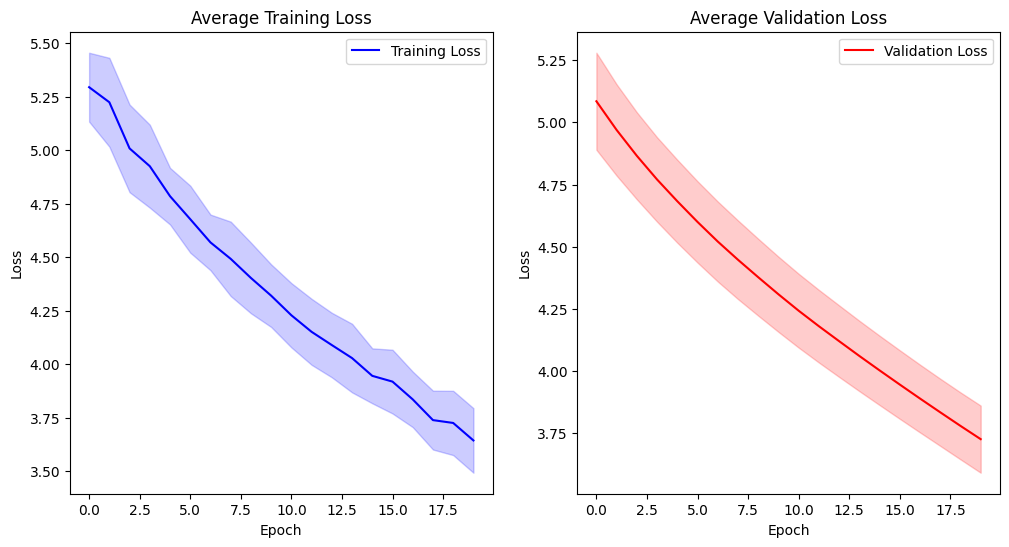

In [13]:
def create_model(l2_reg=0.05):
    model = keras.Sequential([
        keras.layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(l2_reg), input_shape=(X.shape[1],)),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l2(l2_reg)),
        keras.layers.Dense(8, activation='relu'),
        keras.layers.Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

kf = KFold(n_splits=5, shuffle=True, random_state=42)

all_train_losses = []
all_val_losses = []
all_val_accuracies = []

for train_index, test_index in kf.split(X_scaled):
    X_train, X_val = X_scaled[train_index], X_scaled[test_index]
    y_train, y_val = y[train_index], y[test_index]

    model = create_model()
    history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val))

    all_train_losses.append(history.history['loss'])
    all_val_losses.append(history.history['val_loss'])
    all_val_accuracies.append(history.history['val_accuracy'])

mean_train_loss = np.mean(all_train_losses, axis=0)
mean_val_loss = np.mean(all_val_losses, axis=0)
mean_val_accuracy = np.mean(all_val_accuracies, axis=0)

std_train_loss = np.std(all_train_losses, axis=0)
std_val_loss = np.std(all_val_losses, axis=0)
std_val_accuracy = np.std(all_val_accuracies, axis=0)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(mean_train_loss, 'b-', label='Training Loss')
plt.fill_between(range(len(mean_train_loss)),
                 mean_train_loss - std_train_loss,
                 mean_train_loss + std_train_loss,
                 color='blue', alpha=0.2)
plt.title('Average Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mean_val_loss, 'r-', label='Validation Loss')
plt.fill_between(range(len(mean_val_loss)),
                 mean_val_loss - std_val_loss,
                 mean_val_loss + std_val_loss,
                 color='red', alpha=0.2)
plt.title('Average Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Sans régularisation

Epoch 1/20
2/2 [==============================] - 1s 206ms/step - loss: 1.0444 - accuracy: 0.5417 - val_loss: 0.9879 - val_accuracy: 0.5556
Epoch 2/20
2/2 [==============================] - 0s 32ms/step - loss: 0.9528 - accuracy: 0.5556 - val_loss: 0.9622 - val_accuracy: 0.5556
Epoch 3/20
2/2 [==============================] - 0s 34ms/step - loss: 0.8889 - accuracy: 0.5833 - val_loss: 0.9411 - val_accuracy: 0.5556
Epoch 4/20
2/2 [==============================] - 0s 34ms/step - loss: 0.8383 - accuracy: 0.6528 - val_loss: 0.9179 - val_accuracy: 0.5556
Epoch 5/20
2/2 [==============================] - 0s 34ms/step - loss: 0.7960 - accuracy: 0.6944 - val_loss: 0.8950 - val_accuracy: 0.5556
Epoch 6/20
2/2 [==============================] - 0s 36ms/step - loss: 0.7586 - accuracy: 0.7639 - val_loss: 0.8720 - val_accuracy: 0.5556
Epoch 7/20
2/2 [==============================] - 0s 38ms/step - loss: 0.7253 - accuracy: 0.7639 - val_loss: 0.8505 - val_accuracy: 0.6111
Epoch 8/20
2/2 [==========

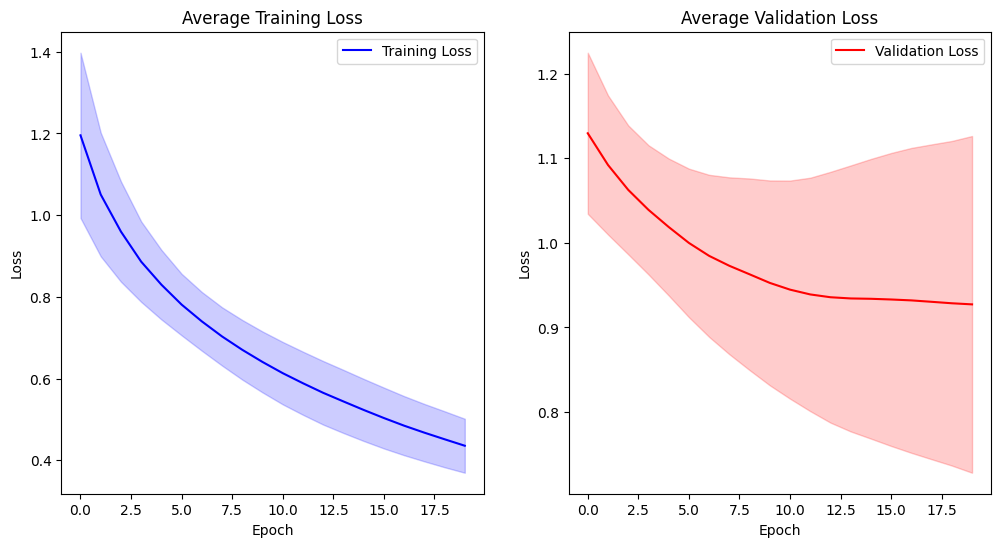

In [ ]:
def create_model():
    model = keras.Sequential([
        keras.layers.Dense(32, activation='relu', input_shape=(X.shape[1],)),
        keras.layers.Dense(16, activation='relu'),
        keras.layers.Dense(8, activation='relu'),
        keras.layers.Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

kf = KFold(n_splits=5, shuffle=True, random_state=42)

all_train_losses = []
all_val_losses = []
all_val_accuracies = []

for train_index, test_index in kf.split(X_scaled):
    X_train, X_val = X_scaled[train_index], X_scaled[test_index]
    y_train, y_val = y[train_index], y[test_index]

    model = create_model()
    history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val))

    all_train_losses.append(history.history['loss'])
    all_val_losses.append(history.history['val_loss'])
    all_val_accuracies.append(history.history['val_accuracy'])

mean_train_loss = np.mean(all_train_losses, axis=0)
mean_val_loss = np.mean(all_val_losses, axis=0)
mean_val_accuracy = np.mean(all_val_accuracies, axis=0)

std_train_loss = np.std(all_train_losses, axis=0)
std_val_loss = np.std(all_val_losses, axis=0)
std_val_accuracy = np.std(all_val_accuracies, axis=0)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(mean_train_loss, 'b-', label='Training Loss')
plt.fill_between(range(len(mean_train_loss)),
                 mean_train_loss - std_train_loss,
                 mean_train_loss + std_train_loss,
                 color='blue', alpha=0.2)
plt.title('Average Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mean_val_loss, 'r-', label='Validation Loss')
plt.fill_between(range(len(mean_val_loss)),
                 mean_val_loss - std_val_loss,
                 mean_val_loss + std_val_loss,
                 color='red', alpha=0.2)
plt.title('Average Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

avec k-fold = 3 au lieu de 5

Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 5.2581 - accuracy: 0.4667 - val_loss: 4.9648 - val_accuracy: 0.5000
Epoch 2/20
1/1 [==============================] - 0s 44ms/step - loss: 5.1631 - accuracy: 0.4833 - val_loss: 4.9148 - val_accuracy: 0.5000
Epoch 3/20
1/1 [==============================] - 0s 64ms/step - loss: 4.9451 - accuracy: 0.4667 - val_loss: 4.8662 - val_accuracy: 0.5000
Epoch 4/20
1/1 [==============================] - 0s 93ms/step - loss: 5.0016 - accuracy: 0.5333 - val_loss: 4.8182 - val_accuracy: 0.5000
Epoch 5/20
1/1 [==============================] - 0s 68ms/step - loss: 4.7049 - accuracy: 0.6000 - val_loss: 4.7702 - val_accuracy: 0.5000
Epoch 6/20
1/1 [==============================] - 0s 58ms/step - loss: 4.7904 - accuracy: 0.6000 - val_loss: 4.7230 - val_accuracy: 0.5000
Epoch 7/20
1/1 [==============================] - 0s 62ms/step - loss: 4.7071 - accuracy: 0.5000 - val_loss: 4.6780 - val_accuracy: 0.5000
Epoch 8/20
1/1 [=============

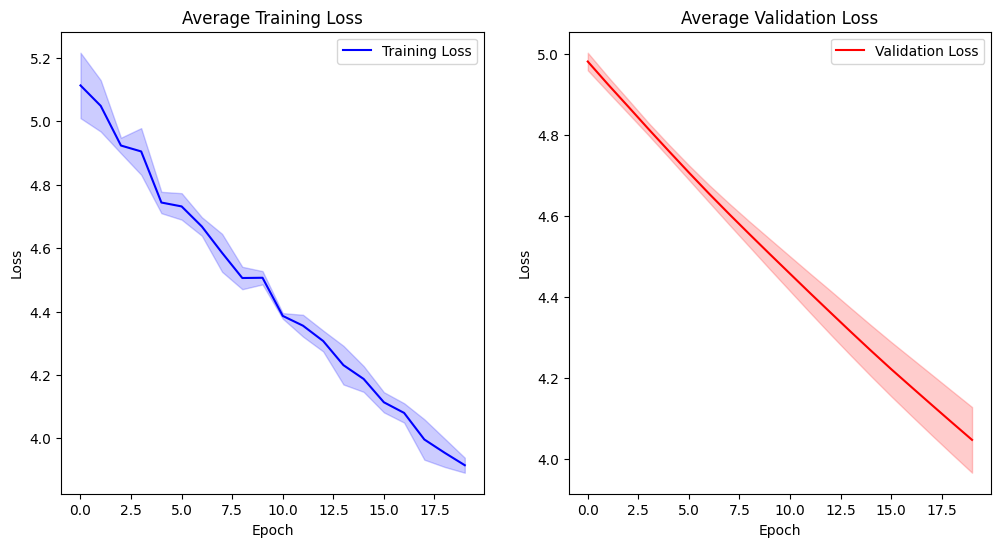

In [ ]:
def create_model(l2_reg=0.05):
    model = keras.Sequential([
        keras.layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(l2_reg), input_shape=(X.shape[1],)),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l2(l2_reg)),
        keras.layers.Dense(8, activation='relu'),
        keras.layers.Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

kf = KFold(n_splits=3, shuffle=True, random_state=42)

all_train_losses = []
all_val_losses = []
all_val_accuracies = []

for train_index, test_index in kf.split(X_scaled):
    X_train, X_val = X_scaled[train_index], X_scaled[test_index]
    y_train, y_val = y[train_index], y[test_index]

    model = create_model()
    history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val))

    all_train_losses.append(history.history['loss'])
    all_val_losses.append(history.history['val_loss'])
    all_val_accuracies.append(history.history['val_accuracy'])

mean_train_loss = np.mean(all_train_losses, axis=0)
mean_val_loss = np.mean(all_val_losses, axis=0)
mean_val_accuracy = np.mean(all_val_accuracies, axis=0)

std_train_loss = np.std(all_train_losses, axis=0)
std_val_loss = np.std(all_val_losses, axis=0)
std_val_accuracy = np.std(all_val_accuracies, axis=0)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(mean_train_loss, 'b-', label='Training Loss')
plt.fill_between(range(len(mean_train_loss)),
                 mean_train_loss - std_train_loss,
                 mean_train_loss + std_train_loss,
                 color='blue', alpha=0.2)
plt.title('Average Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mean_val_loss, 'r-', label='Validation Loss')
plt.fill_between(range(len(mean_val_loss)),
                 mean_val_loss - std_val_loss,
                 mean_val_loss + std_val_loss,
                 color='red', alpha=0.2)
plt.title('Average Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

sur 100 epoch

Epoch 1/100
2/2 [==============================] - 1s 255ms/step - loss: 4.8402 - accuracy: 0.5417 - val_loss: 4.7121 - val_accuracy: 0.5556
Epoch 2/100
2/2 [==============================] - 0s 36ms/step - loss: 4.7480 - accuracy: 0.5972 - val_loss: 4.6230 - val_accuracy: 0.5556
Epoch 3/100
2/2 [==============================] - 0s 34ms/step - loss: 4.6905 - accuracy: 0.5139 - val_loss: 4.5399 - val_accuracy: 0.5556
Epoch 4/100
2/2 [==============================] - 0s 46ms/step - loss: 4.6289 - accuracy: 0.5000 - val_loss: 4.4580 - val_accuracy: 0.6111
Epoch 5/100
2/2 [==============================] - 0s 51ms/step - loss: 4.4920 - accuracy: 0.5000 - val_loss: 4.3784 - val_accuracy: 0.6111
Epoch 6/100
2/2 [==============================] - 0s 51ms/step - loss: 4.3704 - accuracy: 0.5972 - val_loss: 4.3024 - val_accuracy: 0.6111
Epoch 7/100
2/2 [==============================] - 0s 41ms/step - loss: 4.2711 - accuracy: 0.6111 - val_loss: 4.2286 - val_accuracy: 0.6111
Epoch 8/100
2/2 [==

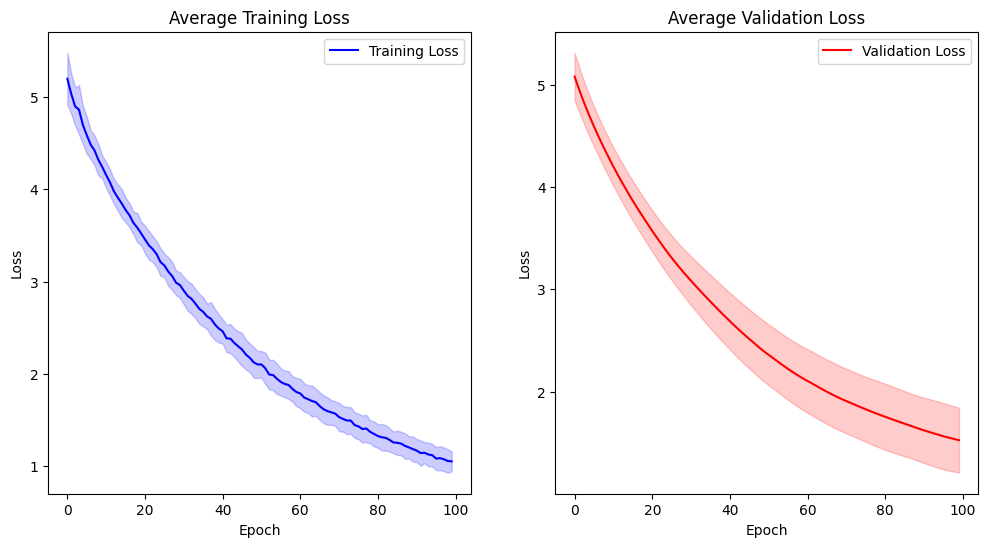

In [ ]:
def create_model(l2_reg=0.05):
    model = keras.Sequential([
        keras.layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(l2_reg), input_shape=(X.shape[1],)),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l2(l2_reg)),
        keras.layers.Dense(8, activation='relu'),
        keras.layers.Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

kf = KFold(n_splits=5, shuffle=True, random_state=42)

all_train_losses = []
all_val_losses = []
all_val_accuracies = []

for train_index, test_index in kf.split(X_scaled):
    X_train, X_val = X_scaled[train_index], X_scaled[test_index]
    y_train, y_val = y[train_index], y[test_index]

    model = create_model()
    history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val))

    all_train_losses.append(history.history['loss'])
    all_val_losses.append(history.history['val_loss'])
    all_val_accuracies.append(history.history['val_accuracy'])

mean_train_loss = np.mean(all_train_losses, axis=0)
mean_val_loss = np.mean(all_val_losses, axis=0)
mean_val_accuracy = np.mean(all_val_accuracies, axis=0)

std_train_loss = np.std(all_train_losses, axis=0)
std_val_loss = np.std(all_val_losses, axis=0)
std_val_accuracy = np.std(all_val_accuracies, axis=0)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(mean_train_loss, 'b-', label='Training Loss')
plt.fill_between(range(len(mean_train_loss)),
                 mean_train_loss - std_train_loss,
                 mean_train_loss + std_train_loss,
                 color='blue', alpha=0.2)
plt.title('Average Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mean_val_loss, 'r-', label='Validation Loss')
plt.fill_between(range(len(mean_val_loss)),
                 mean_val_loss - std_val_loss,
                 mean_val_loss + std_val_loss,
                 color='red', alpha=0.2)
plt.title('Average Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

8 en couche d'entrée au lieu de 32

Epoch 1/20
2/2 [==============================] - 1s 280ms/step - loss: 2.3203 - accuracy: 0.4861 - val_loss: 2.3564 - val_accuracy: 0.5556
Epoch 2/20
2/2 [==============================] - 0s 34ms/step - loss: 2.2389 - accuracy: 0.5417 - val_loss: 2.3274 - val_accuracy: 0.5556
Epoch 3/20
2/2 [==============================] - 0s 52ms/step - loss: 2.2202 - accuracy: 0.5139 - val_loss: 2.3007 - val_accuracy: 0.5556
Epoch 4/20
2/2 [==============================] - 0s 54ms/step - loss: 2.1873 - accuracy: 0.5278 - val_loss: 2.2738 - val_accuracy: 0.5556
Epoch 5/20
2/2 [==============================] - 0s 53ms/step - loss: 2.1407 - accuracy: 0.5694 - val_loss: 2.2462 - val_accuracy: 0.6111
Epoch 6/20
2/2 [==============================] - 0s 55ms/step - loss: 2.0674 - accuracy: 0.6806 - val_loss: 2.2206 - val_accuracy: 0.5556
Epoch 7/20
2/2 [==============================] - 0s 34ms/step - loss: 2.0682 - accuracy: 0.5694 - val_loss: 2.1961 - val_accuracy: 0.5556
Epoch 8/20
2/2 [==========

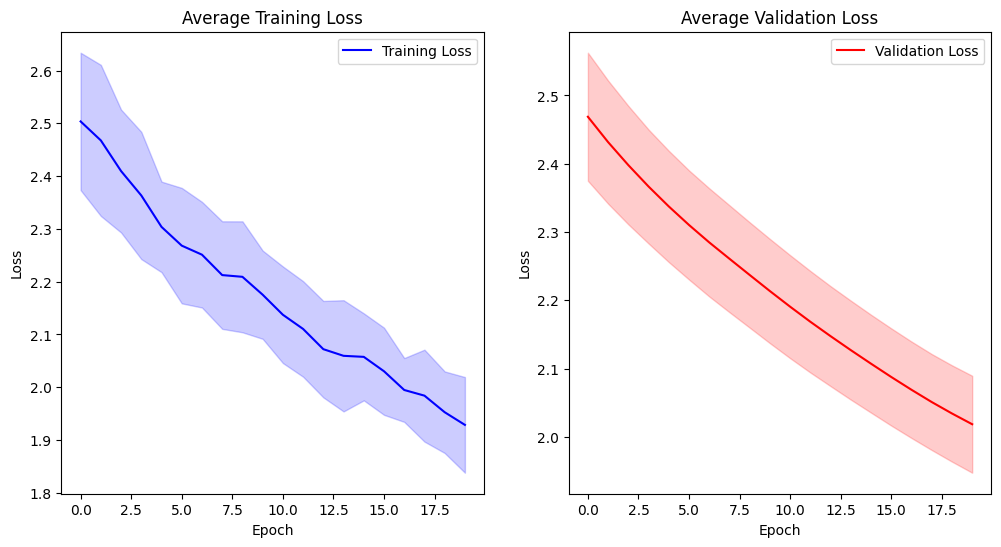

In [ ]:
def create_model(l2_reg=0.05):
    model = keras.Sequential([
        keras.layers.Dense(8, activation='relu', kernel_regularizer=keras.regularizers.l2(l2_reg), input_shape=(X.shape[1],)),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l2(l2_reg)),
        keras.layers.Dense(8, activation='relu'),
        keras.layers.Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

kf = KFold(n_splits=5, shuffle=True, random_state=42)

all_train_losses = []
all_val_losses = []
all_val_accuracies = []

for train_index, test_index in kf.split(X_scaled):
    X_train, X_val = X_scaled[train_index], X_scaled[test_index]
    y_train, y_val = y[train_index], y[test_index]

    model = create_model()
    history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val))

    all_train_losses.append(history.history['loss'])
    all_val_losses.append(history.history['val_loss'])
    all_val_accuracies.append(history.history['val_accuracy'])

mean_train_loss = np.mean(all_train_losses, axis=0)
mean_val_loss = np.mean(all_val_losses, axis=0)
mean_val_accuracy = np.mean(all_val_accuracies, axis=0)

std_train_loss = np.std(all_train_losses, axis=0)
std_val_loss = np.std(all_val_losses, axis=0)
std_val_accuracy = np.std(all_val_accuracies, axis=0)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(mean_train_loss, 'b-', label='Training Loss')
plt.fill_between(range(len(mean_train_loss)),
                 mean_train_loss - std_train_loss,
                 mean_train_loss + std_train_loss,
                 color='blue', alpha=0.2)
plt.title('Average Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mean_val_loss, 'r-', label='Validation Loss')
plt.fill_between(range(len(mean_val_loss)),
                 mean_val_loss - std_val_loss,
                 mean_val_loss + std_val_loss,
                 color='red', alpha=0.2)
plt.title('Average Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

tout à 8 neurones

Epoch 1/20
2/2 [==============================] - 1s 366ms/step - loss: 3.1541 - accuracy: 0.2222 - val_loss: 2.6108 - val_accuracy: 0.1111
Epoch 2/20
2/2 [==============================] - 0s 106ms/step - loss: 3.1032 - accuracy: 0.1944 - val_loss: 2.5605 - val_accuracy: 0.1111
Epoch 3/20
2/2 [==============================] - 0s 36ms/step - loss: 2.8773 - accuracy: 0.2222 - val_loss: 2.5129 - val_accuracy: 0.1111
Epoch 4/20
2/2 [==============================] - 0s 94ms/step - loss: 2.9694 - accuracy: 0.1944 - val_loss: 2.4672 - val_accuracy: 0.1111
Epoch 5/20
2/2 [==============================] - 0s 42ms/step - loss: 2.7601 - accuracy: 0.2778 - val_loss: 2.4262 - val_accuracy: 0.1111
Epoch 6/20
2/2 [==============================] - 0s 52ms/step - loss: 2.7695 - accuracy: 0.2500 - val_loss: 2.3918 - val_accuracy: 0.1111
Epoch 7/20
2/2 [==============================] - 0s 35ms/step - loss: 2.6885 - accuracy: 0.2917 - val_loss: 2.3608 - val_accuracy: 0.1111
Epoch 8/20
2/2 [=========

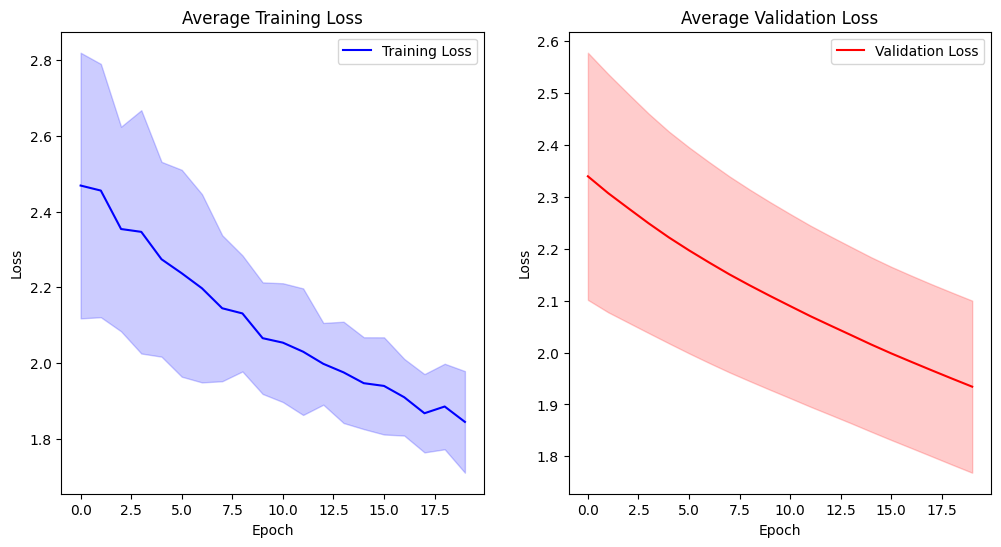

In [ ]:
def create_model(l2_reg=0.05):
    model = keras.Sequential([
        keras.layers.Dense(8, activation='relu', kernel_regularizer=keras.regularizers.l2(l2_reg), input_shape=(X.shape[1],)),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(8, activation='relu', kernel_regularizer=keras.regularizers.l2(l2_reg)),
        keras.layers.Dense(8, activation='relu'),
        keras.layers.Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

kf = KFold(n_splits=5, shuffle=True, random_state=42)

all_train_losses = []
all_val_losses = []
all_val_accuracies = []

for train_index, test_index in kf.split(X_scaled):
    X_train, X_val = X_scaled[train_index], X_scaled[test_index]
    y_train, y_val = y[train_index], y[test_index]

    model = create_model()
    history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val))

    all_train_losses.append(history.history['loss'])
    all_val_losses.append(history.history['val_loss'])
    all_val_accuracies.append(history.history['val_accuracy'])

mean_train_loss = np.mean(all_train_losses, axis=0)
mean_val_loss = np.mean(all_val_losses, axis=0)
mean_val_accuracy = np.mean(all_val_accuracies, axis=0)

std_train_loss = np.std(all_train_losses, axis=0)
std_val_loss = np.std(all_val_losses, axis=0)
std_val_accuracy = np.std(all_val_accuracies, axis=0)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(mean_train_loss, 'b-', label='Training Loss')
plt.fill_between(range(len(mean_train_loss)),
                 mean_train_loss - std_train_loss,
                 mean_train_loss + std_train_loss,
                 color='blue', alpha=0.2)
plt.title('Average Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mean_val_loss, 'r-', label='Validation Loss')
plt.fill_between(range(len(mean_val_loss)),
                 mean_val_loss - std_val_loss,
                 mean_val_loss + std_val_loss,
                 color='red', alpha=0.2)
plt.title('Average Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()